# Generalized Piecewise Function Plotter

This notebook allows you to plot arbitrary piecewise functions across different year segments.
Each segment can have its own custom function of compute (or any other variable).


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable, List, Tuple, Optional

# ---------- EDITABLE PARAMETERS ----------
# Year→Compute mapping: C(year) = C0 * exp(k * (year - y0))
y0 = 2013
C0 = 1e16                 # compute at reference year
k  = np.log(4.1) / 1.0    # NATURAL log: 4.1x every 1.0 year

# Optional: Baseline function (can be None if you don't want a baseline)
# This function takes compute C as input and returns loss
def baseline_func(C):
    """Baseline power law: L = A0 * C^(-alpha0) + E"""
    A0, alpha0, E = 35.5, 0.064, 1.8
    return A0 * (C ** (-alpha0)) + E

# Disjoint algorithmic segments: (start_year, end_year, function, label)
# Each function should take compute C as input and return loss
# You can use lambda functions or define functions above

# Example 1: Power law segments (original behavior)
segments = [
    (2015, 2017, lambda C: 35.5 * (C ** (-0.064)) + 1.8, "Segment 1"),
    (2017, 2019, lambda C: 80.6 * (C ** (-0.075)) + 1.8, "Segment 2"),
    (2019, 2021, lambda C: 80.6 * (C ** (-0.075)) + 1.8, "Segment 3"),
    (2022, 2023, lambda C: 80.6 * (C ** (-0.091)) + 1.8, "Segment 4"),
]

# Example 2: Arbitrary functions (commented out - uncomment to use)
# segments = [
#     (2017, 2019, lambda C: (C/1e17)**2 + 2, "Quadratic"),
#     (2019, 2022, lambda C: 10 * np.cos(C/1e17) + 12, "Cosine"),
#     (2022, 2023, lambda C: 50 * np.exp(-C/1e18) + 5, "Exponential"),
# ]

# Transition labels (shown between segments)
transition_labels = ["Transformer", "Post to Pre Layernorm", "Rotary\nEncoding"]

# Year window
plot_year_start, plot_year_end = 2015.0, 2023.0

# Appearance
segment_color = "#5ec8ff"   # light blue for all segments
transition_color = "blue"
baseline_color = "black"
efficiency_color = "green"

# Y-axis limits (log-scale)
ylim_lower = 10**0.25
ylim_upper = 10**2

# Whether to show baseline (set to False if baseline_func is None)
show_baseline = True

# Whether to show efficiency line (only works if baseline_func exists)
show_efficiency = True


In [3]:
# ---------- HELPER FUNCTIONS ----------

def year_to_compute(year):
    """Convert year to compute using exponential growth model"""
    return C0 * np.exp(k * (year - y0))

def loss_at_year_from_segments(year):
    """Evaluate the piecewise function at a given year"""
    chosen = None
    for (ys, ye, func, label) in segments:
        if ys <= year <= ye:
            chosen = func
            break
        if ye < year:
            chosen = func
    
    if chosen is None:
        if baseline_func is not None:
            return baseline_func(year_to_compute(year))
        else:
            # If no baseline and year is before first segment, use first segment
            return segments[0][2](year_to_compute(year))
    
    return chosen(year_to_compute(year))

# Compute range for plotting
compute_min = year_to_compute(plot_year_start)
compute_max = year_to_compute(plot_year_end)
print(f"Compute range: {compute_min:.2e} → {compute_max:.2e}")


Compute range: 1.68e+17 → 1.34e+22


Saved to: Figures/generalized_piecewise_plot.png


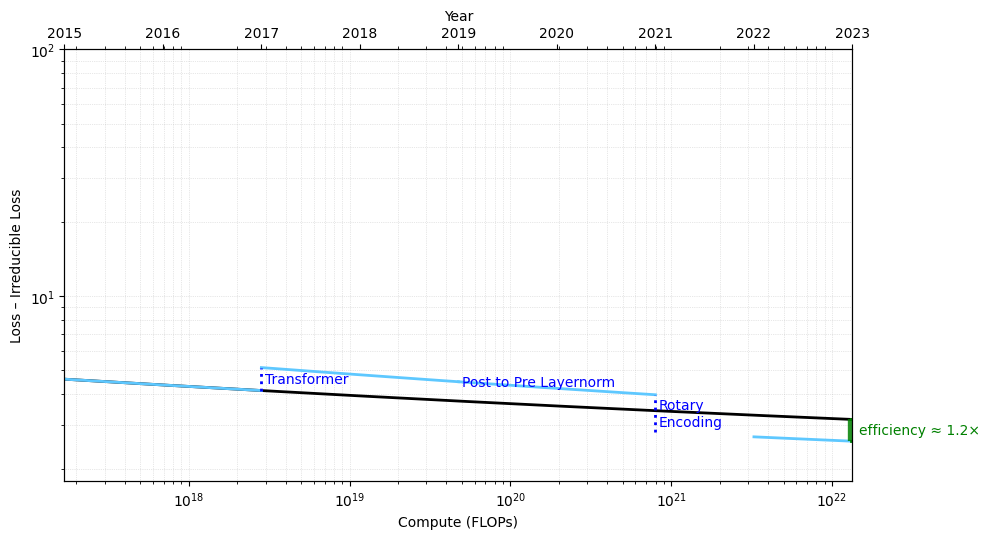

In [4]:
# ---------- PLOTTING ----------

fig, ax = plt.subplots(figsize=(10, 5.5))

# Axes on log scales
ax.set_xscale('log')
ax.set_yscale('log')

# Force x-limits to the compute range
ax.set_xlim(compute_min, compute_max)
ax.set_ylim(ylim_lower, ylim_upper)

# Labels
ax.set_xlabel("Compute (FLOPs)")
ax.set_ylabel("Loss – Irreducible Loss")

# Plot baseline curve (if enabled)
if show_baseline and baseline_func is not None:
    C_grid = np.logspace(np.log10(compute_min), np.log10(compute_max), 1200)
    try:
        baseline_values = baseline_func(C_grid)
        ax.plot(C_grid, baseline_values, color=baseline_color, linewidth=2, label='Baseline')
    except Exception as e:
        print(f"Warning: Could not plot baseline: {e}")

# Plot algorithmic segments (uniform color)
for (ys, ye, func, label) in segments:
    ys_c, ye_c = max(ys, plot_year_start), min(ye, plot_year_end)
    if ye_c <= ys_c:
        continue
    
    years = np.linspace(ys_c, ye_c, 200)
    C_seg = year_to_compute(years)
    
    try:
        L_seg = func(C_seg)
        ax.plot(C_seg, L_seg, color=segment_color, linewidth=2)
    except Exception as e:
        print(f"Warning: Could not plot segment '{label}': {e}")

# Plot transition lines + labels
for i in range(len(segments) - 1):
    _, ye, func1, label1 = segments[i]
    ys2, _, func2, label2 = segments[i + 1]
    
    t = ye
    C_t = year_to_compute(t)
    
    try:
        L1 = func1(C_t)
        L2 = func2(C_t)
        
        # Vertical dotted line at transition
        ax.plot([C_t, C_t], [min(L1, L2), max(L1, L2)],
                linestyle=":", linewidth=2, color=transition_color)
        
        # Label at geometric mean height
        y_mid = (L1 * L2) ** 0.5
        trans_label = transition_labels[i] if i < len(transition_labels) else f"Δ{i+1}"
        ax.text(C_t * 1.05, y_mid, trans_label, color=transition_color, va='center')
    except Exception as e:
        print(f"Warning: Could not plot transition {i}: {e}")

# Green vertical efficiency line (if enabled)
if show_efficiency and baseline_func is not None:
    final_year = min(plot_year_end, segments[-1][1])
    C_final = year_to_compute(final_year)
    
    try:
        L_algo_final = loss_at_year_from_segments(final_year)
        L_base_final = baseline_func(C_final)
        
        ax.vlines(C_final, ymin=L_algo_final, ymax=L_base_final,
                  color=efficiency_color, linewidth=6, alpha=0.85)
        
        # Little ticks at ends
        ax.plot([C_final * 0.98, C_final * 1.02], [L_base_final, L_base_final],
                color=efficiency_color, linewidth=2)
        ax.plot([C_final * 0.98, C_final * 1.02], [L_algo_final, L_algo_final],
                color=efficiency_color, linewidth=2)
        
        # Efficiency label
        efficiency_ratio = L_base_final / L_algo_final if L_algo_final > 0 else 1.0
        eff_text = f"efficiency ≈ {efficiency_ratio:.1e}×" if efficiency_ratio > 1e6 else f"efficiency ≈ {efficiency_ratio:,.1f}×"
        ax.text(C_final * 1.10, (L_algo_final * L_base_final) ** 0.5, eff_text,
                color=efficiency_color, va='center')
    except Exception as e:
        print(f"Warning: Could not plot efficiency line: {e}")

# Top axis: years mapped to the same log x
ax_top = ax.twiny()
ax_top.set_xscale('log')
ax_top.set_xlim(ax.get_xlim())
years = np.arange(int(np.floor(plot_year_start)), int(np.ceil(plot_year_end)) + 1)
tick_positions = year_to_compute(years)
mask = (tick_positions >= compute_min) & (tick_positions <= compute_max)
ax_top.set_xticks(tick_positions[mask])
ax_top.set_xticklabels([str(y) for y in years[mask]])
ax_top.set_xlabel("Year")

# Styling
ax.grid(True, which="both", linestyle=":", linewidth=0.5, alpha=0.6)
plt.tight_layout()

# Save figure
out_path = "Figures/generalized_piecewise_plot.png"
plt.savefig(out_path, dpi=200, bbox_inches="tight")
print(f"Saved to: {out_path}")
plt.show()


## Example Usage

Here are some examples of how to define different types of functions for segments:

### 1. Power Law (original)
```python
segments = [
    (2017, 2019, lambda C: 35.5 * (C ** (-0.064)) + 1.8, "Power Law"),
]
```

### 2. Quadratic
```python
segments = [
    (2017, 2019, lambda C: (C/1e17)**2 + 2, "Quadratic"),
]
```

### 3. Trigonometric
```python
segments = [
    (2019, 2022, lambda C: 10 * np.cos(C/1e17) + 12, "Cosine"),
    (2022, 2023, lambda C: 10 * np.sin(C/1e17) + 12, "Sine"),
]
```

### 4. Exponential
```python
segments = [
    (2017, 2019, lambda C: 50 * np.exp(-C/1e18) + 5, "Exponential Decay"),
    (2019, 2022, lambda C: 5 * np.exp(C/1e19), "Exponential Growth"),
]
```

### 5. Logarithmic
```python
segments = [
    (2017, 2019, lambda C: 20 - 5 * np.log10(C/1e16), "Logarithmic"),
]
```

### 6. Custom Complex Function
```python
def my_custom_function(C):
    """Some complex behavior"""
    normalized_C = C / 1e17
    return 10 / (1 + normalized_C**2) + 3

segments = [
    (2017, 2019, my_custom_function, "Custom"),
]
```

### 7. Your Example: x² then cos(x)
```python
segments = [
    (2017, 2019, lambda C: (C/1e17)**2 + 2, "Quadratic x²"),
    (2019, 2022, lambda C: 10 * np.cos(C/1e17) + 12, "Cosine"),
]
```
